## Project 3 - Webscraping (Nootropics v Supplement subreddits)

### Imports

In [59]:
import pandas as pd
import numpy as np
from psaw import PushshiftAPI
import datetime as dt
from bs4 import BeautifulSoup 
import requests
import re
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn import svm, datasets
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Webscraping Setup

In [3]:
url = 'https://www.reddit.com/r/Nootropics.json'

In [4]:
headers = {'User-agent': 'Edubs'}

In [5]:
res = requests.get(url, headers=headers)
res.status_code

200

In [6]:
jsondict = res.json()

In [7]:
sorted(jsondict['data'].keys())

['after', 'before', 'children', 'dist', 'modhash']

In [8]:
[post['data']['name'] for post in jsondict['data']['children']]

['t3_5yisj3',
 't3_783dac',
 't3_aau3ns',
 't3_aaxal2',
 't3_aavbno',
 't3_aampot',
 't3_aawlxo',
 't3_aawkny',
 't3_aamwgz',
 't3_aaw5wh',
 't3_aapaj2',
 't3_aav70p',
 't3_aatumm',
 't3_aahdr1',
 't3_aaqpm2',
 't3_aaki9o',
 't3_aaohr8',
 't3_aarkko',
 't3_aamhl4',
 't3_aam2a3',
 't3_aapqfr',
 't3_aapdv1',
 't3_aam1yn',
 't3_aaky1g',
 't3_aao7n1',
 't3_aao77m',
 't3_aao2ug']

In [9]:
param = {'after':'t3_a7v54a'}

In [10]:
requests.get(url, params=param, headers=headers)

<Response [200]>

### Getting Nootropics subreddit Data

In [11]:
posts = []
after = None
for x in range(35):
    print(x)
    if after == None:
        params = {}
    else:
        params = {'after': after}
    url = 'https://www.reddit.com/r/Nootropics.json'
    res = requests.get(url, params=params, headers=headers)
    if res.status_code == 200:
        jsondict = res.json()
        posts.extend(jsondict['data']['children'])
        after= jsondict['data']['after']
    else:
        print(res.status_code)
        break
    time.sleep(2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


In [12]:
len(set([p['data']['name'] for p in posts]))

765

### Nooptropics subreddit data to Dataframe and CSV

In [13]:
title = []
for x in range(0, len(posts)):
    title.append(posts[x]['data']['title'])

nootropics = pd.DataFrame(title)
nootropics['target'] = 0
nootropics.drop_duplicates(inplace=True)
nootropics.to_csv('nootropics.csv')
nootropics.shape

(764, 2)

### Getting Supplment Subreddit Data

In [14]:
posts2 = []
after = None
for x in range(35):
    print(x)
    if after == None:
        params = {}
    else:
        params = {'after': after}
    url = 'https://www.reddit.com/r/Supplements.json'
    res = requests.get(url, params=params, headers=headers)
    if res.status_code == 200:
        jsondict = res.json()
        posts2.extend(jsondict['data']['children'])
        after= jsondict['data']['after']
    else:
        print(res.status_code)
        break
    time.sleep(2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


In [15]:
len(set([p['data']['name'] for p in posts2]))

877

### Supplement subreddit data to Dataframe and CSV

In [16]:
title = []
for x in range(0, len(posts2)):
    title.append(posts2[x]['data']['title'])

supp = pd.DataFrame(title)
supp['target'] = 1
supp.head
supp.drop_duplicates(inplace=True)
supp.to_csv('supp.csv')
supp.shape

(876, 2)

### Concating Subreddits to 1 data frame and formatting (Note: Target is supplement and assigned to 1)

In [17]:
df = pd.concat([nootropics, supp], axis = 0)
df = pd.DataFrame(df)
df.drop_duplicates(inplace=True)
df['target'].value_counts()
df.columns = ['title', 'target']
df.reset_index(inplace=True, drop=True)
df.shape

(1640, 2)

### Count Vectorization for top 15 common words for Supplement and Nootropics 

In [18]:
cv = CountVectorizer(stop_words='english')
dfcv = cv.fit_transform(df['title'])
plot1 = pd.DataFrame(dfcv.toarray(), columns=cv.get_feature_names())
plot1.index = df['target']
print('Nootropics top common words list')
print(plot1[plot1.index ==0].sum().sort_values(ascending=False).head(15)) 
print()
print('Supplements top common words list')
print(plot1[plot1.index ==1].sum().sort_values(ascending=False).head(15))

Nootropics top common words list
nootropics     47
brain          42
effects        42
does           41
2018           33
ashwagandha    30
nootropic      30
caffeine       29
sleep          29
theanine       27
cognitive      27
effect         27
long           26
experience     26
oil            25
dtype: int64

Supplements top common words list
supplements    131
vitamin         85
supplement      64
best            49
magnesium       48
taking          47
oil             37
does            36
help            34
creatine        33
workout         32
protein         31
good            28
d3              28
pre             26
dtype: int64


Text(0.5,1,'Nootropics top list')

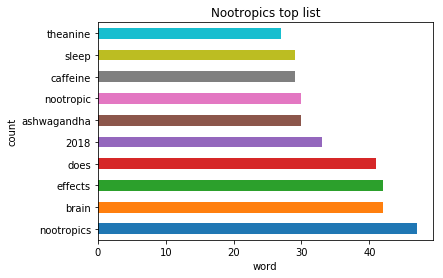

In [47]:
noop = plot1[plot1.index ==0].sum().sort_values(ascending=False).head(10).plot(kind='barh')
noop.set_ylabel('count')
noop.set_xlabel('word')
plt.title('Nootropics top list')

Text(0.5,1,'Supplement top list')

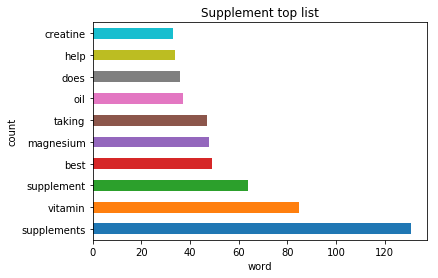

In [48]:
supps = plot1[plot1.index ==1].sum().sort_values(ascending=False).head(10).plot(kind='barh')
supps.set_ylabel('count')
supps.set_xlabel('word')
plt.title('Supplement top list')

### Train Test Split

In [19]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['target'])

### Count Vectorizer Fitting to Train data

In [20]:
vect = CountVectorizer(stop_words='english', analyzer='word')
X_text = vect.fit_transform(X_train)
X_trainfit = pd.DataFrame(X_text.toarray(), columns=vect.get_feature_names())

In [21]:
pd.DataFrame(X_trainfit.sum().sort_values(ascending=False).head(20), columns=['freq']).T

,supplements,vitamin,supplement,does,taking,oil,best,magnesium,brain,effects,sleep,good,nootropics,2018,ashwagandha,caffeine,help,theanine,experience,amp
freq,117,81,63,52,50,48,47,43,42,42,37,35,35,34,34,32,31,30,28,28


Text(0.5,0,'Word')

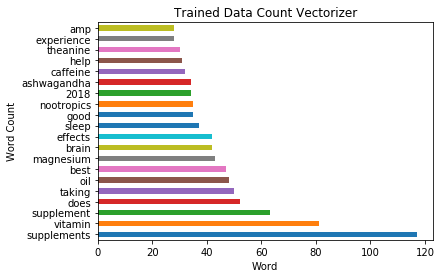

In [49]:
#Shows top Results for supplements subreddit
ax = X_trainfit.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Trained Data Count Vectorizer')
ax.set_ylabel('Word Count')
ax.set_xlabel('Word')

#### Count Vecotrizer Fitting to Test data

In [23]:
X_textvect = vect.transform(X_test)
X_testfit = pd.DataFrame(X_textvect.toarray(), columns=vect.get_feature_names())

Text(0.5,0,'Words')

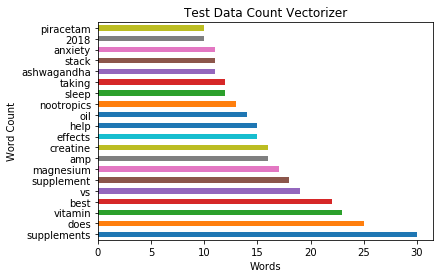

In [50]:
#Shows top Results for supplements subreddit
ax = X_testfit.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Test Data Count Vectorizer')
ax.set_ylabel('Word Count')
ax.set_xlabel('Words')

### TFIDF Model

Text(0.5,0,'Words')

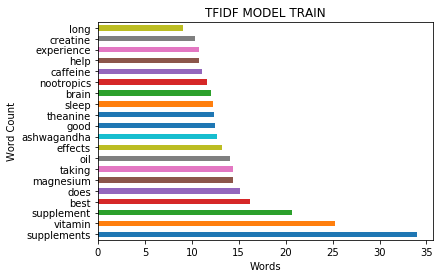

In [51]:
tvec = TfidfVectorizer(stop_words='english')
trainme = tvec.fit_transform(X_train) 
train_tvec = pd.DataFrame(trainme.toarray(), columns=tvec.get_feature_names())
ax =train_tvec.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('TFIDF MODEL TRAIN')
ax.set_ylabel('Word Count')
ax.set_xlabel('Words')

Text(0.5,0,'Words')

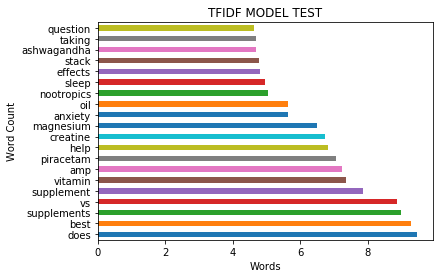

In [52]:
testme = tvec.transform(X_test) 
test_tvec = pd.DataFrame(testme.toarray(), columns=tvec.get_feature_names())
ax = test_tvec.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('TFIDF MODEL TEST')
ax.set_ylabel('Word Count')
ax.set_xlabel('Words')

## Remaining Classifiers will use TDIF (I tried both get better fitting with Count Vectorizer NOT TFIDF)

### Random Forest Classification

In [27]:
rf = RandomForestClassifier()
rf_params = {'n_estimators' : [30,35,40,45,50],
             'max_depth': [None, 1,2,3,4,5],
             'min_samples_split':[5,6,7,8,9,10] }
gs = GridSearchCV(rf, param_grid=rf_params)
gs.fit(X_text, y_train)
print('Random Forest Classifier')
print('Base Accuracy = ', gs.score(X_text, y_train))
print('Best Parameters: ', gs.best_params_) 
print('Best Score = ', gs.best_score_)
print('Test Score = ', gs.score(X_textvect, y_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Random Forest Classifier
Base Accuracy =  0.9626016260162602
Best Parameters:  {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
Best Score =  0.7341463414634146
Test Score =  0.7341463414634146


### Naive Bayes

In [28]:
nb = MultinomialNB()
NB = nb.fit(X_trainfit, y_train)
nbpred = nb.predict(X_testfit)
print('Naive Bayes')
print('Base Accuracy = ', NB.score(X_trainfit, y_train))
print('Test Score = ', NB.score(X_testfit, y_test))

Naive Bayes
Base Accuracy =  0.9292682926829269
Test Score =  0.7682926829268293


### KNN Classifier

In [29]:
ss = StandardScaler()
ss.fit(X_trainfit)
ssX = ss.transform(X_trainfit) 
ssXtest = ss.transform(X_testfit)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(ssX, y_train)
print('KNN Classifier')
print('Base Accuracy = ', knn.score(ssX, y_train))
print('Test Score = ', knn.score(ssXtest, y_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


KNN Classifier
Base Accuracy =  0.5682926829268292
Test Score =  0.5560975609756098


### Support Vector Model

In [30]:
svc = svm.SVC(C = 80, kernel= 'rbf', gamma = .001)
svc.fit(X_trainfit, y_train)
svcXpred = svc.predict(X_trainfit)
svcpred = svc.predict(X_testfit)
print('Support Vector Model')
print('Base Accuracy = ', accuracy_score(svcXpred, y_train))
print('Test Score = ',accuracy_score(svcpred, y_test))

Support Vector Model
Base Accuracy =  0.9292682926829269
Test Score =  0.7536585365853659


### Logistic Regression Model

In [31]:
lr = LogisticRegression()
lr.fit(X_trainfit, y_train)
predictions = lr.predict(X_testfit)
print('Logistic Regression')
print('Base accuracy = ' ,lr.score(X_trainfit, y_train))
print('Test accuracy = ' ,lr.score(X_testfit, y_test))

Logistic Regression
Base accuracy =  0.9585365853658536
Test accuracy =  0.7731707317073171


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Best Model base/test scores = Logistic Regression

### Confusion Matrix Logistic Regression

In [74]:
confusion_matrix(y_test, predictions)

array([[132,  54],
       [ 39, 185]], dtype=int64)

In [75]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [76]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 132
False Positives: 54
False Negatives: 39
True Positives: 185


Text(33,0.5,'Actual')

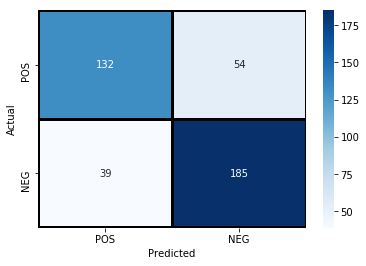

In [93]:
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, predictions), ['POS' ,'NEG'],['POS' ,'NEG']), annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')